# Packages

In [1]:
!pip install torchmetrics tqdm --upgrade

# Imports

In [2]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader, random_split

from torchmetrics.text import Perplexity

import tqdm

from collections import Counter

Setting ds_accelerator to cuda (auto detect)


2023-09-23 20:44:07.719716: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-23 20:44:08.348058: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Configuration

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
seq_len = 21
batch_size = 25
min_freq = 0

num_epochs = 300

max_lr_dec = 3
lr_dec = 0

# Utils

In [4]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [5]:
def num_trainable_params(model):
  nums = sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6
  return nums

# Dataset

In [7]:
tokenizer = get_tokenizer("moses")

In [8]:
def load_dataset(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        dataset = file.read()
    return dataset

def tokenize_dataset(dataset):
    tokens = []
    for line in dataset.split('\n'):
        line_tokens = tokenizer(line.strip())
        tokens.extend(line_tokens)
    return tokens

In [9]:

train_dataset = load_dataset("../penn/train.txt")
valid_dataset = load_dataset("../penn/valid.txt")
test_dataset = load_dataset("../penn/test.txt")

train_tokens = tokenize_dataset(train_dataset)
valid_tokens = tokenize_dataset(valid_dataset)
test_tokens = tokenize_dataset(test_dataset)

all_tokens = train_tokens + valid_tokens + test_tokens
print("Train Tokens: " , len(train_tokens))
print("Valid Tokens: " , len(valid_tokens))
print("Test Tokens: " , len(test_tokens))
print("Total number of tokens:", len(all_tokens))

Train Tokens:  995961
Valid Tokens:  78880
Test Tokens:  90103
Total number of tokens: 1164944


In [10]:
tokenized_datasets = [train_tokens] 

special_tokens = ['<pad>', '<unk>', '<bos>', '<eos>']

vocab = build_vocab_from_iterator(tokenized_datasets, specials=special_tokens , min_freq=min_freq)

vocab.set_default_index(vocab['<unk>'])

vocab_size = len(vocab)
vocab_itos = vocab.get_itos()

torch.save(vocab, f"./train_vocab_moses_{min_freq}.voc")
print("Vocabulary size:", vocab_size)

Vocabulary size: 10021


## Custom Dataset

In [11]:
class Wikitext2Dataset(Dataset):
  def __init__(self, tokens, seq_len):
    self.tokens = tokens
    self.seq_len = seq_len
  def __len__(self):
    return  len(self.tokens) // self.seq_len

  def __getitem__(self, idx):
    start_idx = idx * self.seq_len
    end_idx = start_idx + self.seq_len
    input = self.tokens[start_idx:end_idx]
    target = self.tokens[start_idx+1:end_idx+1]
    return torch.tensor(input), torch.tensor(target)

## Load Dataset

In [12]:
train_tokens_voc = vocab(train_tokens)
valid_tokens_voc = vocab(valid_tokens)
test_tokens_voc = vocab(test_tokens)

# Datasets
train_dataset = Wikitext2Dataset(train_tokens_voc, seq_len)
valid_dataset = Wikitext2Dataset(valid_tokens_voc, seq_len)
test_dataset = Wikitext2Dataset(test_tokens_voc, seq_len)

# Dataloaders
train_loader = DataLoader(train_dataset , batch_size )
valid_loader = DataLoader(valid_dataset , batch_size )
test_loader = DataLoader(test_dataset , batch_size )

# Model

In [13]:
class H_LSTM(nn.Module):

  def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate):
    super().__init__()
    self.vocab_size = vocab_size
    
    #Embedding Layer
    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.dropout_em = nn.Dropout(0.1)
    
    # Layer 1
    self.rnn1 = nn.LSTM(input_size=embedding_dim,
                      hidden_size=hidden_dim,
                      num_layers=num_layers,
                      bidirectional=False,
                      batch_first=True)
    self.dropout1 = nn.Dropout(dropout_rate)
    
    # Layer 2
    self.rnn2 = nn.LSTM(input_size=hidden_dim,
                      hidden_size=hidden_dim,
                      num_layers=num_layers,
                      bidirectional=False,
                      batch_first=True)
    self.dropout2 = nn.Dropout(dropout_rate)
    
    # Layer 3
    self.rnn3 = nn.LSTM(input_size=hidden_dim,
                      hidden_size=hidden_dim,
                      num_layers=1,
                      bidirectional=False,
                      batch_first=True)
    self.dropout3 = nn.Dropout(dropout_rate)
    
    self.fc = nn.Linear(hidden_dim,vocab_size,bias=True)

  def forward(self, src):
    embedding = self.dropout_em( self.embedding(src) )
    
    output, _ = self.rnn1(embedding)
    output = self.dropout1(output)
    
    output, _  = self.rnn2(output)
    output = self.dropout2(output)
    
    output, _ = self.rnn3(output)
    output = self.dropout3(output)
    
    output = self.fc(output)
    return output


# Train

## Learning Functions

In [14]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, perp , epoch=1):
  
  global seq_len
  global batch_size
  
  model.train()
  loss_train = AverageMeter()
  perplexity_train = AverageMeter()
    
  with tqdm.tqdm(train_loader, unit='batch') as tepoch:
    for inputs, targets in tepoch:

      tepoch.set_description(f'Epoch {epoch}')

      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)

      batch_size, seq_len, vocab_size = outputs.size()
      outputs = outputs.view(batch_size * seq_len, vocab_size)
      targets = targets.view(-1)
      
      loss = loss_fn(outputs, targets)
      
      loss.backward()
      
      perplexity = perp(outputs.view(batch_size, seq_len, vocab_size), targets.view(batch_size, seq_len))
      
      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item(), n=len(targets))
      perplexity_train.update(perplexity.item(), n=len(targets))

      tepoch.set_postfix(loss=loss_train.avg, perplexity = perplexity_train.avg )
      
      del inputs
      del targets
      del outputs

  return model, loss_train.avg, perplexity_train.avg 

In [15]:
def evaluate(model, test_loader, loss_fn , perp ):
  
  global seq_len
  global batch_size
  
  model.eval()
  loss_eval = AverageMeter()
  perplexity_eval = AverageMeter()

  with torch.inference_mode():
    for inputs, targets in test_loader:
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)
      
      batch_size, seq_len, vocab_size = outputs.size()
      outputs = outputs.view(batch_size * seq_len, vocab_size)
      targets = targets.view(-1)

      loss = loss_fn(outputs, targets)
      
      perplexity = perp(outputs.view(batch_size, seq_len, vocab_size), targets.view(batch_size, seq_len))

      loss_eval.update(loss.item(), n=len(targets))
      perplexity_eval.update(perplexity.item(), n=len(targets))
      
      del inputs
      del targets
      del outputs

  return loss_eval.avg,perplexity_eval.avg

## Parameters

In [16]:
embedding_dim = 256
hidden_dim = 256
num_layers = 1
dropout_rate = 0.25

model = H_LSTM( vocab_size, embedding_dim=embedding_dim, hidden_dim=hidden_dim , num_layers=num_layers, dropout_rate= dropout_rate )
loss_train_hist = []
loss_valid_hist = []

per_train_hist = []
per_valid_hist = []

lr_train_hist = []

best_perplexity_valid = torch.inf
epoch_counter = 0
print(f"Trainable Parameters: {num_trainable_params(model)}\n")
model = model.to(device)
model

Trainable Parameters: 6.719781



H_LSTM(
  (embedding): Embedding(10021, 256)
  (dropout_em): Dropout(p=0.1, inplace=False)
  (rnn1): LSTM(256, 256, batch_first=True)
  (dropout1): Dropout(p=0.25, inplace=False)
  (rnn2): LSTM(256, 256, batch_first=True)
  (dropout2): Dropout(p=0.25, inplace=False)
  (rnn3): LSTM(256, 256, batch_first=True)
  (dropout3): Dropout(p=0.25, inplace=False)
  (fc): Linear(in_features=256, out_features=10021, bias=True)
)

## Learning Loop

In [17]:
lr = 0.5
wd = 1e-5
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9)
loss_fn = nn.CrossEntropyLoss()  
perp = Perplexity().to(device)

In [18]:
num_epochs = 300
max_lr_dec = 4
lr_dec = 0

for epoch in range(num_epochs):
  # Train
  model, loss_train, per_train = train_one_epoch(model, train_loader, loss_fn, optimizer, perp , epoch)
  # Validation
  loss_valid, per_val = evaluate(model, valid_loader, loss_fn, perp)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  per_train_hist.append(per_train)
  per_valid_hist.append(per_val)

  lr_train_hist.append(lr)
  
  print(f'Valid: Loss = {loss_valid:.4} Perplexity= {per_val:.4}, LR = {lr}')
  epoch_counter += 1
  
  if per_val < best_perplexity_valid:
    lr_dec = 0
    torch.save(model, f'model.pt')
    best_perplexity_valid = per_val
    print('Model Saved!')
  else:
    if lr_dec >= max_lr_dec :
      print("LR_DEC==3 , Finished")
      break
    lr_dec += 1
    
    del model
    del perp
    del loss_fn
    del optimizer
    
    model_path = 'model.pt'
    model = torch.load(model_path,map_location=device)
    lr /= 2
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9)
    loss_fn = nn.CrossEntropyLoss()
    perp = Perplexity().to(device)
  print()
  

Epoch 0: 100%|██████████| 1898/1898 [01:01<00:00, 31.05batch/s, loss=5.64, perplexity=372]   


Valid: Loss = 5.182 Perplexity= 192.2, LR = 0.5
Model Saved!



Epoch 1: 100%|██████████| 1898/1898 [01:00<00:00, 31.24batch/s, loss=5.12, perplexity=178]


Valid: Loss = 4.956 Perplexity= 153.5, LR = 0.5
Model Saved!



Epoch 2: 100%|██████████| 1898/1898 [00:57<00:00, 32.90batch/s, loss=4.94, perplexity=149]


Valid: Loss = 4.843 Perplexity= 137.7, LR = 0.5
Model Saved!



Epoch 3: 100%|██████████| 1898/1898 [00:59<00:00, 31.68batch/s, loss=4.82, perplexity=133]


Valid: Loss = 4.766 Perplexity= 127.9, LR = 0.5
Model Saved!



Epoch 4: 100%|██████████| 1898/1898 [00:58<00:00, 32.19batch/s, loss=4.74, perplexity=122]


Valid: Loss = 4.711 Perplexity= 121.6, LR = 0.5
Model Saved!



Epoch 5: 100%|██████████| 1898/1898 [00:59<00:00, 31.72batch/s, loss=4.67, perplexity=114]


Valid: Loss = 4.674 Perplexity= 117.6, LR = 0.5
Model Saved!



Epoch 6: 100%|██████████| 1898/1898 [00:59<00:00, 31.68batch/s, loss=4.61, perplexity=109]


Valid: Loss = 4.639 Perplexity= 113.7, LR = 0.5
Model Saved!



Epoch 7: 100%|██████████| 1898/1898 [00:59<00:00, 31.75batch/s, loss=4.56, perplexity=104]


Valid: Loss = 4.614 Perplexity= 111.1, LR = 0.5
Model Saved!



Epoch 8: 100%|██████████| 1898/1898 [00:58<00:00, 32.54batch/s, loss=4.52, perplexity=99.6]


Valid: Loss = 4.599 Perplexity= 109.2, LR = 0.5
Model Saved!



Epoch 9: 100%|██████████| 1898/1898 [00:59<00:00, 31.78batch/s, loss=4.49, perplexity=96.1]


Valid: Loss = 4.575 Perplexity= 107.1, LR = 0.5
Model Saved!



Epoch 10: 100%|██████████| 1898/1898 [00:59<00:00, 31.83batch/s, loss=4.45, perplexity=93.1]


Valid: Loss = 4.564 Perplexity= 105.9, LR = 0.5
Model Saved!



Epoch 11: 100%|██████████| 1898/1898 [00:59<00:00, 31.82batch/s, loss=4.42, perplexity=90.4]


Valid: Loss = 4.55 Perplexity= 104.7, LR = 0.5
Model Saved!



Epoch 12: 100%|██████████| 1898/1898 [00:59<00:00, 31.66batch/s, loss=4.39, perplexity=87.6]


Valid: Loss = 4.534 Perplexity= 103.1, LR = 0.5
Model Saved!



Epoch 13: 100%|██████████| 1898/1898 [00:58<00:00, 32.50batch/s, loss=4.37, perplexity=85.5]


Valid: Loss = 4.527 Perplexity= 102.4, LR = 0.5
Model Saved!



Epoch 14: 100%|██████████| 1898/1898 [00:59<00:00, 31.69batch/s, loss=4.34, perplexity=83.4]


Valid: Loss = 4.516 Perplexity= 101.2, LR = 0.5
Model Saved!



Epoch 15: 100%|██████████| 1898/1898 [00:59<00:00, 31.78batch/s, loss=4.32, perplexity=81.3]


Valid: Loss = 4.511 Perplexity= 100.8, LR = 0.5
Model Saved!



Epoch 16: 100%|██████████| 1898/1898 [00:59<00:00, 31.92batch/s, loss=4.3, perplexity=79.6] 


Valid: Loss = 4.502 Perplexity= 100.1, LR = 0.5
Model Saved!



Epoch 17: 100%|██████████| 1898/1898 [00:59<00:00, 32.03batch/s, loss=4.27, perplexity=78]  


Valid: Loss = 4.498 Perplexity= 99.49, LR = 0.5
Model Saved!



Epoch 18: 100%|██████████| 1898/1898 [00:58<00:00, 32.24batch/s, loss=4.25, perplexity=76.5]


Valid: Loss = 4.502 Perplexity= 100.1, LR = 0.5



Epoch 19: 100%|██████████| 1898/1898 [01:00<00:00, 31.28batch/s, loss=4.17, perplexity=70.2]


Valid: Loss = 4.44 Perplexity= 94.03, LR = 0.25
Model Saved!



Epoch 20: 100%|██████████| 1898/1898 [01:01<00:00, 30.86batch/s, loss=4.14, perplexity=68.2]


Valid: Loss = 4.435 Perplexity= 93.63, LR = 0.25
Model Saved!



Epoch 21: 100%|██████████| 1898/1898 [01:01<00:00, 30.91batch/s, loss=4.12, perplexity=67.1]


Valid: Loss = 4.435 Perplexity= 93.63, LR = 0.25
Model Saved!



Epoch 22: 100%|██████████| 1898/1898 [01:01<00:00, 30.98batch/s, loss=4.11, perplexity=66.2]


Valid: Loss = 4.437 Perplexity= 93.97, LR = 0.25



Epoch 23: 100%|██████████| 1898/1898 [01:01<00:00, 30.90batch/s, loss=4.06, perplexity=63]  


Valid: Loss = 4.406 Perplexity= 91.04, LR = 0.125
Model Saved!



Epoch 24: 100%|██████████| 1898/1898 [00:58<00:00, 32.18batch/s, loss=4.04, perplexity=61.9]


Valid: Loss = 4.403 Perplexity= 90.85, LR = 0.125
Model Saved!



Epoch 25: 100%|██████████| 1898/1898 [01:00<00:00, 31.17batch/s, loss=4.03, perplexity=61.1]


Valid: Loss = 4.401 Perplexity= 90.58, LR = 0.125
Model Saved!



Epoch 26: 100%|██████████| 1898/1898 [01:00<00:00, 31.16batch/s, loss=4.02, perplexity=60.5]


Valid: Loss = 4.399 Perplexity= 90.46, LR = 0.125
Model Saved!



Epoch 27: 100%|██████████| 1898/1898 [01:01<00:00, 30.91batch/s, loss=4.01, perplexity=59.9]


Valid: Loss = 4.396 Perplexity= 90.23, LR = 0.125
Model Saved!



Epoch 28: 100%|██████████| 1898/1898 [01:01<00:00, 30.98batch/s, loss=4, perplexity=59.4]   


Valid: Loss = 4.396 Perplexity= 90.15, LR = 0.125
Model Saved!



Epoch 29: 100%|██████████| 1898/1898 [00:59<00:00, 31.83batch/s, loss=3.99, perplexity=59]  


Valid: Loss = 4.397 Perplexity= 90.33, LR = 0.125



Epoch 30: 100%|██████████| 1898/1898 [01:00<00:00, 31.50batch/s, loss=3.97, perplexity=57.4]


Valid: Loss = 4.384 Perplexity= 89.16, LR = 0.0625
Model Saved!



Epoch 31: 100%|██████████| 1898/1898 [01:00<00:00, 31.18batch/s, loss=3.96, perplexity=56.8]


Valid: Loss = 4.385 Perplexity= 89.26, LR = 0.0625



Epoch 32: 100%|██████████| 1898/1898 [01:00<00:00, 31.28batch/s, loss=3.94, perplexity=56.1]


Valid: Loss = 4.378 Perplexity= 88.74, LR = 0.03125
Model Saved!



Epoch 33: 100%|██████████| 1898/1898 [01:00<00:00, 31.39batch/s, loss=3.94, perplexity=55.8]


Valid: Loss = 4.379 Perplexity= 88.79, LR = 0.03125



Epoch 34: 100%|██████████| 1898/1898 [01:00<00:00, 31.63batch/s, loss=3.93, perplexity=55.4]


Valid: Loss = 4.375 Perplexity= 88.43, LR = 0.015625
Model Saved!



Epoch 35: 100%|██████████| 1898/1898 [01:00<00:00, 31.50batch/s, loss=3.93, perplexity=55.2]


Valid: Loss = 4.374 Perplexity= 88.34, LR = 0.015625
Model Saved!



Epoch 36: 100%|██████████| 1898/1898 [00:58<00:00, 32.54batch/s, loss=3.92, perplexity=55]  


Valid: Loss = 4.374 Perplexity= 88.3, LR = 0.015625
Model Saved!



Epoch 37: 100%|██████████| 1898/1898 [00:57<00:00, 33.11batch/s, loss=3.92, perplexity=55]  


Valid: Loss = 4.374 Perplexity= 88.35, LR = 0.015625



Epoch 38: 100%|██████████| 1898/1898 [00:57<00:00, 33.25batch/s, loss=3.92, perplexity=54.8]


Valid: Loss = 4.371 Perplexity= 88.07, LR = 0.0078125
Model Saved!



Epoch 39: 100%|██████████| 1898/1898 [00:57<00:00, 33.15batch/s, loss=3.92, perplexity=54.6]


Valid: Loss = 4.37 Perplexity= 88.0, LR = 0.0078125
Model Saved!



Epoch 40: 100%|██████████| 1898/1898 [00:55<00:00, 33.96batch/s, loss=3.91, perplexity=54.5]


Valid: Loss = 4.37 Perplexity= 87.98, LR = 0.0078125
Model Saved!



Epoch 41: 100%|██████████| 1898/1898 [00:57<00:00, 33.16batch/s, loss=3.91, perplexity=54.4]


Valid: Loss = 4.37 Perplexity= 88.0, LR = 0.0078125



Epoch 42: 100%|██████████| 1898/1898 [00:56<00:00, 33.31batch/s, loss=3.91, perplexity=54.4]


Valid: Loss = 4.369 Perplexity= 87.92, LR = 0.00390625
Model Saved!



Epoch 43: 100%|██████████| 1898/1898 [00:56<00:00, 33.36batch/s, loss=3.91, perplexity=54.4]


Valid: Loss = 4.369 Perplexity= 87.88, LR = 0.00390625
Model Saved!



Epoch 44: 100%|██████████| 1898/1898 [00:57<00:00, 33.27batch/s, loss=3.91, perplexity=54.3]


Valid: Loss = 4.369 Perplexity= 87.86, LR = 0.00390625
Model Saved!



Epoch 45: 100%|██████████| 1898/1898 [00:56<00:00, 33.82batch/s, loss=3.91, perplexity=54.2]


Valid: Loss = 4.369 Perplexity= 87.87, LR = 0.00390625



Epoch 46: 100%|██████████| 1898/1898 [00:57<00:00, 33.16batch/s, loss=3.91, perplexity=54.2]


Valid: Loss = 4.368 Perplexity= 87.82, LR = 0.001953125
Model Saved!



Epoch 47: 100%|██████████| 1898/1898 [00:57<00:00, 33.08batch/s, loss=3.91, perplexity=54.1]


Valid: Loss = 4.368 Perplexity= 87.82, LR = 0.001953125
Model Saved!



Epoch 48: 100%|██████████| 1898/1898 [01:00<00:00, 31.43batch/s, loss=3.91, perplexity=54.1]


Valid: Loss = 4.368 Perplexity= 87.81, LR = 0.001953125
Model Saved!



Epoch 49: 100%|██████████| 1898/1898 [01:00<00:00, 31.13batch/s, loss=3.91, perplexity=54.1]


Valid: Loss = 4.368 Perplexity= 87.81, LR = 0.001953125
Model Saved!



Epoch 50: 100%|██████████| 1898/1898 [00:59<00:00, 31.69batch/s, loss=3.91, perplexity=54.1]


Valid: Loss = 4.368 Perplexity= 87.79, LR = 0.001953125
Model Saved!



Epoch 51: 100%|██████████| 1898/1898 [01:01<00:00, 30.92batch/s, loss=3.91, perplexity=54]  


Valid: Loss = 4.368 Perplexity= 87.81, LR = 0.001953125



Epoch 52: 100%|██████████| 1898/1898 [01:01<00:00, 30.81batch/s, loss=3.91, perplexity=54.1]


Valid: Loss = 4.368 Perplexity= 87.77, LR = 0.0009765625
Model Saved!



Epoch 53: 100%|██████████| 1898/1898 [01:01<00:00, 31.01batch/s, loss=3.91, perplexity=54]  


Valid: Loss = 4.368 Perplexity= 87.78, LR = 0.0009765625



Epoch 54: 100%|██████████| 1898/1898 [00:48<00:00, 39.24batch/s, loss=3.9, perplexity=54]   


Valid: Loss = 4.368 Perplexity= 87.75, LR = 0.00048828125
Model Saved!



Epoch 55: 100%|██████████| 1898/1898 [00:44<00:00, 42.93batch/s, loss=3.91, perplexity=54]  


Valid: Loss = 4.368 Perplexity= 87.76, LR = 0.00048828125



Epoch 56: 100%|██████████| 1898/1898 [00:44<00:00, 42.85batch/s, loss=3.9, perplexity=54]   


Valid: Loss = 4.367 Perplexity= 87.75, LR = 0.000244140625
Model Saved!



Epoch 57: 100%|██████████| 1898/1898 [00:44<00:00, 42.61batch/s, loss=3.9, perplexity=53.9] 


Valid: Loss = 4.368 Perplexity= 87.75, LR = 0.000244140625



Epoch 58: 100%|██████████| 1898/1898 [00:44<00:00, 42.77batch/s, loss=3.9, perplexity=54]   


Valid: Loss = 4.368 Perplexity= 87.75, LR = 0.0001220703125



Epoch 59: 100%|██████████| 1898/1898 [00:42<00:00, 45.03batch/s, loss=3.9, perplexity=53.9] 


Valid: Loss = 4.368 Perplexity= 87.75, LR = 6.103515625e-05



Epoch 60: 100%|██████████| 1898/1898 [00:42<00:00, 44.86batch/s, loss=3.9, perplexity=54]   


Valid: Loss = 4.367 Perplexity= 87.75, LR = 3.0517578125e-05
Model Saved!



Epoch 61: 100%|██████████| 1898/1898 [00:41<00:00, 46.17batch/s, loss=3.9, perplexity=53.9] 


Valid: Loss = 4.368 Perplexity= 87.75, LR = 3.0517578125e-05



Epoch 62: 100%|██████████| 1898/1898 [00:40<00:00, 46.74batch/s, loss=3.9, perplexity=53.9] 


Valid: Loss = 4.368 Perplexity= 87.75, LR = 1.52587890625e-05



Epoch 63: 100%|██████████| 1898/1898 [00:42<00:00, 44.32batch/s, loss=3.9, perplexity=53.9] 


Valid: Loss = 4.368 Perplexity= 87.75, LR = 7.62939453125e-06



Epoch 64: 100%|██████████| 1898/1898 [00:43<00:00, 43.96batch/s, loss=3.9, perplexity=53.9] 


Valid: Loss = 4.367 Perplexity= 87.75, LR = 3.814697265625e-06



Epoch 65: 100%|██████████| 1898/1898 [00:43<00:00, 43.22batch/s, loss=3.9, perplexity=54]   


Valid: Loss = 4.367 Perplexity= 87.75, LR = 1.9073486328125e-06
LR_DEC==3 , Finished


## Learning Curve

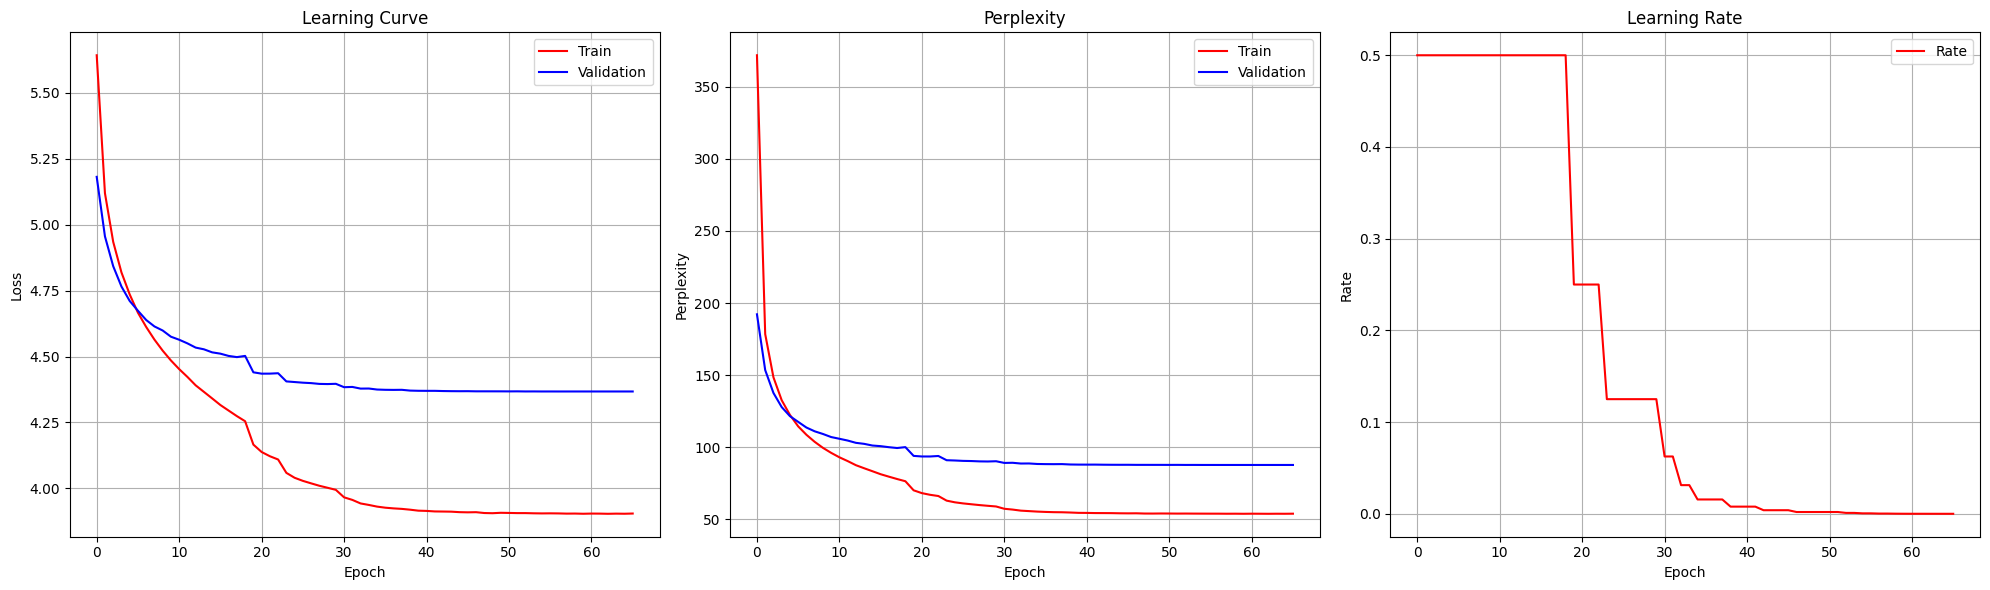

In [19]:
# Save as CSV
import pandas as pd
datas = {
    'epoch': range(epoch_counter),
    'loss_train': loss_train_hist,
    'loss_validation': loss_valid_hist,
    'perplexity_train': per_train_hist , 
    'perplexity_validation':per_valid_hist,
    'learning_rate': lr_train_hist
}
df = pd.DataFrame(datas)
df.to_csv("learningCurve.csv" , index=False)

fig, (ax1, ax2 , ax3) = plt.subplots(1, 3, figsize=(20, 6))

ax1.plot(range(epoch_counter), loss_train_hist, 'r-', label='Train')
ax1.plot(range(epoch_counter), loss_valid_hist, 'b-', label='Validation')
ax1.set_title('Learning Curve')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.grid(True)
ax1.legend()

ax2.plot(range(epoch_counter), per_train_hist, 'r-', label='Train')
ax2.plot(range(epoch_counter), per_valid_hist, 'b-', label='Validation')
ax2.set_title('Perplexity')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Perplexity')
ax2.grid(True)
ax2.legend()

ax3.plot(range(epoch_counter), lr_train_hist, 'r-', label='Rate')
ax3.set_title('Learning Rate')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Rate')
ax3.grid(True)
ax3.legend()

plt.tight_layout()
plt.show()

## Test Perplexity

In [20]:
model_path = 'model.pt'
model = torch.load(model_path)
model = model.to(device)
model.eval()

loss_fn = nn.CrossEntropyLoss()
perp = Perplexity().to(device)

loss_valid , per_valid  = evaluate(model, valid_loader, loss_fn , perp )
print(f"Validation: Loss = {loss_valid:.4} , Perplexity = {per_valid:.4}")

loss_test , per_test  = evaluate(model, test_loader, loss_fn , perp)
print(f"Test: Loss = {loss_test:.4} , Perplexity = {per_test:.4}")

Validation: Loss = 4.367 , Perplexity = 87.75
Test: Loss = 4.237 , Perplexity = 74.87


# Text Generation

In [21]:
loss_fn = nn.CrossEntropyLoss()

model_path = 'model.pt'
model = torch.load(model_path)
model = model.to(device)
model.eval()
model

H_LSTM(
  (embedding): Embedding(10021, 256)
  (dropout_em): Dropout(p=0.1, inplace=False)
  (rnn1): LSTM(256, 256, batch_first=True)
  (dropout1): Dropout(p=0.25, inplace=False)
  (rnn2): LSTM(256, 256, batch_first=True)
  (dropout2): Dropout(p=0.25, inplace=False)
  (rnn3): LSTM(256, 256, batch_first=True)
  (dropout3): Dropout(p=0.25, inplace=False)
  (fc): Linear(in_features=256, out_features=10021, bias=True)
)

In [22]:
num_trainable_params(model)

6.719781

In [23]:
def generate(prompt, max_seq_len, temperature, model ):

    global device
    global vocab_itos
    global seq_len
    global char2ind
    
    prompt_tokens = prompt.split(' ')
    prompt_tokens = [vocab[token] for token in prompt_tokens]  

    with torch.no_grad():
        current_token = torch.tensor(prompt_tokens).unsqueeze(0) 
        current_token = current_token.to(device)
        generated_text = prompt  
        for i in range(max_seq_len):
            output = model(current_token)
            probabilities = nn.functional.softmax(output[:, -1, :] / temperature, dim=-1)
            next_word = "<unk>"
            while next_word == "<unk>":
                next_token_id = torch.multinomial(probabilities, 1).item()
                next_word = vocab_itos[next_token_id]
            
            generated_text += " " + next_word

            next_token_id = torch.tensor([[next_token_id]]).to(device)
            if current_token.shape[1] < seq_len:
                current_token = torch.cat( ( current_token  , next_token_id ), dim=1)
            else:
                current_token = torch.cat( ( current_token[:, 1:]  , next_token_id ), dim=1)
            if next_word in ["<eos>", "."]:
                break
            del next_token_id
    return generated_text

prompt = "i think the movie"
generated_text = generate(prompt, 
                          max_seq_len = 100, 
                          temperature = 0.2, 
                          model = model)

print(generated_text)

i think the movie is n &apos;t going to be a &lt; unk &gt; &lt; unk &gt; &lt; unk &gt; &lt; unk &gt; &lt; unk &gt; &lt; unk &gt; &lt; unk &gt; &lt; unk &gt; &lt; unk &gt; &lt; unk &gt; &lt; unk &gt; &lt; unk &gt; &lt; unk &gt; &lt; unk &gt; &lt; unk &gt; &lt; unk &gt; &lt; unk &gt; &lt; unk &gt; &lt; unk &gt; &lt; unk &gt; &lt; unk &gt; &lt; unk &gt; &lt; unk &gt; &lt; unk &gt; &lt; unk &gt; &lt; unk &gt; &lt; unk &gt; &lt; unk &gt; &lt; unk &gt; &lt; unk &gt; &lt; unk &gt;
